In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [3]:
from sklearn.utils import shuffle

In [4]:
df = pd.read_csv('data/ratings_preprocessed.csv', index_col=0)

In [5]:
df.head()

,rating,userId,movieId
0,4.0,193,1744
1,4.5,417,1744
2,3.5,914,1744
3,3.0,813,572
4,2.5,193,261


In [6]:
df = df[(df['movieId'] < 2000) & (df['userId'] < 8000)]

In [6]:
print(f'The number of ratings in the dataset is {df.shape[0]}')
print(f'The number of users in the dataset is {df.userId.nunique()}')
print(f'The number of movies in the dataset is {df.movieId.nunique()}')

The number of ratings in the dataset is 5392234
The number of users in the dataset is 10000
The number of movies in the dataset is 2000


In [7]:
N = df.userId.max() + 1
M = df.movieId.max() + 1

In [8]:
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [9]:
print(f'The number of users in the training dataset is {df_train.shape[0]}')
print(f'The number of users in the test dataset is {df_test.shape[0]}')

The number of users in the training dataset is 4313787
The number of users in the test dataset is 1078447


In [10]:
K = 20
mu = df_train.rating.mean()
epochs = 25
reg = 0. # regularization penalty

**Building Layers of the Neural Network**

In [11]:
u = layers.Input(shape=(1, ))
m = layers.Input(shape=(1, ))
u_embedding = layers.Embedding(N, K, embeddings_regularizer=l2(reg))(u)
m_embedding = layers.Embedding(M, K, embeddings_regularizer=l2(reg))(m)

Metal device set to: Apple M1 Pro


2022-12-25 21:30:01.190323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-25 21:30:01.190528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
u_bias = layers.Embedding(N, 1, embeddings_regularizer=l2(reg))(u)
m_bias = layers.Embedding(M, 1, embeddings_regularizer=l2(reg))(m)

In [13]:
x = layers.Dot(axes=2)([u_embedding, m_embedding])

In [14]:
x = layers.Add()([x, u_bias, m_bias])

In [15]:
x = layers.Flatten()(x)

In [16]:
model = Model(inputs=[u, m], outputs=x)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 20)        200000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 20)        40000       ['input_2[0][0]']                
                                                                                              

In [18]:
model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=[MeanSquaredError()]
)

In [19]:
history = model.fit(
    x = [df_train['userId'].values, df_train['movieId'].values],
    y = df_train['rating'].values - mu,
    epochs = epochs,
    batch_size = 128,
    validation_split=0.2
)

Epoch 1/25


2022-12-25 21:30:16.716488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-25 21:30:16.984230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26962/26962 [==============================] - ETA: 0s - loss: 0.8000 - mean_squared_error: 0.8000

2022-12-25 21:33:19.656101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26962/26962 [==============================] - 206s 8ms/step - loss: 0.8000 - mean_squared_error: 0.8000 - val_loss: 0.7207 - val_mean_squared_error: 0.7207
Epoch 2/25
26962/26962 [==============================] - 204s 8ms/step - loss: 0.7016 - mean_squared_error: 0.7016 - val_loss: 0.6870 - val_mean_squared_error: 0.6870
Epoch 3/25
26962/26962 [==============================] - 200s 7ms/step - loss: 0.6811 - mean_squared_error: 0.6811 - val_loss: 0.6761 - val_mean_squared_error: 0.6761
Epoch 4/25
26962/26962 [==============================] - 321s 12ms/step - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.6720 - val_mean_squared_error: 0.6720
Epoch 5/25
26962/26962 [==============================] - 202s 7ms/step - loss: 0.6706 - mean_squared_error: 0.6706 - val_loss: 0.6703 - val_mean_squared_error: 0.6703
Epoch 6/25
26962/26962 [==============================] - 201s 7ms/step - loss: 0.6693 - mean_squared_error: 0.6693 - val_loss: 0.6695 - val_mean_squared_error: 0.6695
Ep

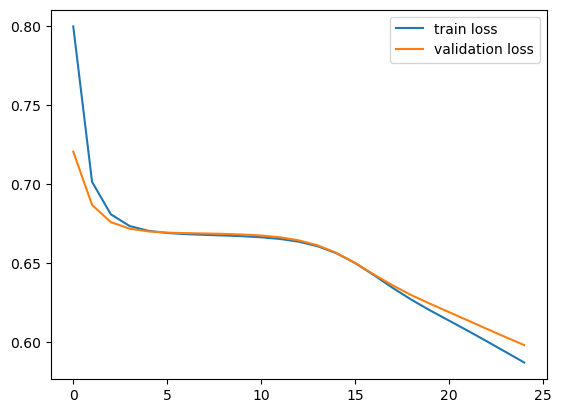

In [20]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

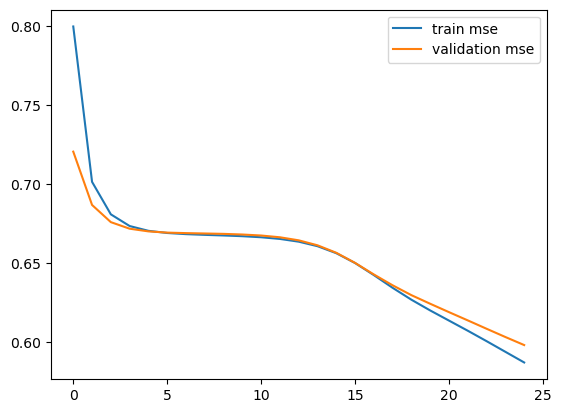

In [21]:
plt.plot(history.history['mean_squared_error'], label="train mse")
plt.plot(history.history['val_mean_squared_error'], label="validation mse")
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(
    [df_train.userId.values, df_train.movieId.values],
    batch_size=128
)

y_true = df_train.rating.values - mu
mse = MeanSquaredError()
print(f'The Trianing MSE is {mse(y_true, y_pred).numpy()}')

   49/33702 [..............................] - ETA: 1:48

2022-12-25 22:57:45.067993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33702/33702 [==============================] - 80s 2ms/step
The Trianing MSE is 0.584852933883667


In [23]:
y_pred = model.predict(
    [df_test.userId.values, df_test.movieId.values]
)

y_true = df_test.rating.values - mu
mse = MeanSquaredError()
print(f'The test MSE is {mse(y_true, y_pred).numpy()}')

33702/33702 [==============================] - 82s 2ms/step
The test MSE is 0.6023701429367065


In [26]:
from tensorflow.keras import backend as K

In [27]:
K.clear_session()